In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 1
import os
from PIL import Image
import imageio
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!date

2018年 10月 25日 星期四 23:03:59 CST


In [27]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-10-24_00-00-13_noup'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ../data/prepare_weight/2018-10-24_00-00-13_noup


# 初始化棋局

In [111]:
HUMAN_FIRST = False
MOVE = 'human' if HUMAN_FIRST else 'computer'

In [112]:
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
moves = []
#for i in moves[:]: 
#   statestr = GameBoard.sim_do_action(i,statestr)
#   imgs_for_gif.append(board_visualizer.get_board_img(statestr))
#   state.do_moae(i)
#mgs_for_gif = imgs_for_gif[:]
#mageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

# 从这里开始下棋

In [123]:
assert(MOVE in ['human','computer'])
if MOVE == 'human':
    move = input()
    while (move not in GameBoard.get_legal_moves(statestr,current_player=state.currentplayer)):
        print("invalid move {}, please reinput:".format(move))
        move = input()
    MOVE = 'computer'
else:
    network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=1600,
                                           temp_round=2,repeat_noise=False,c_puct=5,dnoise=True,is_selfplay=True)
    move = network_player.make_move(state=state,actual_move=False)[0]
    MOVE = 'human'
moves.append(move)

h0g2


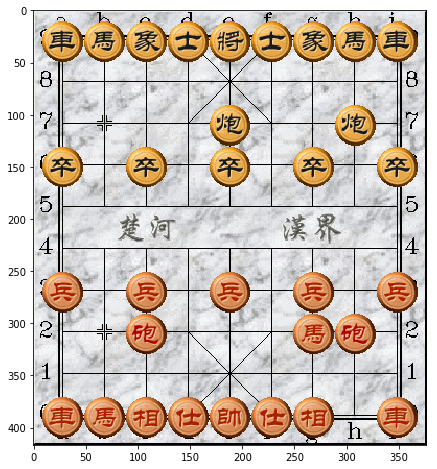

In [124]:
statestr = GameBoard.sim_do_action(move,statestr)
state.do_move(move)
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))
print(move)

# analysis

In [125]:
for move in network_player.mcts_policy._root._children:
    node = network_player.mcts_policy._root._children[move]
    print(move,node._n_visits,node._P,node._Q)

a0a1 30 4.9485798e-06 -0.024301835074826767
a0a2 28 1.3585105e-05 -0.006858573877252639
a3a4 27 1.1047184e-05 -0.002861668459243243
b0a2 35 0.002058117 0.07734968523894037
c2a2 27 2.9211635e-06 -0.05068993464940124
c2b2 24 4.7128487e-06 -0.09897564781325249
c2d2 23 9.569789e-06 -0.04415942860119369
c2e2 27 7.811104e-06 -0.025523271433215727
c2f2 23 2.6366135e-06 -0.064312062955097
c2g2 26 1.0264325e-06 -0.06239490053401543
c2c1 26 9.506109e-06 -0.034103832028519646
c2c6 25 6.6849775e-06 -0.09430458952672778
c3c4 27 2.4607662e-05 -0.009470044824950119
e0e1 23 4.3962523e-06 -0.04761058656984698
e3e4 29 8.582461e-06 -0.01769469561183761
g3g4 33 1.1820021e-05 0.015603991310027513
h0g2 486 0.9126949 0.05531650554537755
h0i2 39 0.021219658 0.03659087716965961
h2d2 37 8.846625e-06 0.07530223510253267
h2e2 33 0.0023839648 0.07981073586129103
h2f2 30 0.00027515323 0.033139165583997966
h2g2 37 0.0038606664 0.0659542562458916
h2i2 36 0.00561707 0.05079910169135675
h2h1 30 9.05157e-05 0.0084087938

In [126]:
network

((<tensorflow.python.client.session.Session at 0x7f2e06cabc88>,
  <tensorflow.python.framework.ops.Graph at 0x7f2e0629b160>),
 ((<tf.Tensor 'Placeholder:0' shape=(?, 10, 9, 14) dtype=float32>,
   <tf.Tensor 'training_mode:0' shape=<unknown> dtype=bool>),
  (<tf.Tensor 'concat_200:0' shape=(?, 2086) dtype=float32>,
   <tf.Tensor 'concat_201:0' shape=(?, 1) dtype=float32>)))

In [117]:
graph = network[0][1]
sess = network[0][0]

In [118]:
import tensorflow as tf
with graph.as_default():
    regularizer = tf.contrib.layers.l2_regularizer(scale=1e-4)
    regular_variables = tf.trainable_variables()
    l2_loss = tf.contrib.layers.apply_regularization(regularizer, regular_variables)

In [119]:
with graph.as_default():
    print(sess.run(l2_loss))

0.23983414
